In [3]:
import sys
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, random
#from sklearn.decomposition import PCA
import sklearn.linear_model
import tensorflow as tf
from tensorflow.keras import layers

sys.path.insert(0,'radiative_models')
import radiative_models
reload(radiative_models)
#import radiative_models as rm

<module 'radiative_models' from 'radiative_models/radiative_models.py'>

In [4]:
X_train, Y_train, grid = radiative_models.generate_opticallythin_spectra(10000)#generate_spectra(10000)
X_test, Y_test, grid = radiative_models.generate_opticallythin_spectra(1000)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

New resolution:  0.2013 +/- 0.0
Nan values:  False
New resolution:  0.2013 +/- 0.0
Nan values:  False


((10000, 149), (10000,), (1000, 149), (1000,))

In [20]:
grid[0]

array([  7.85758485,   6.06358248,  86.07883267, 269.35401307])

## Logistic Regression: sklearn

In [111]:
def run_LR_tensorflow(X_train, Y_train, X_test, Y_test):
    clf = sklearn.linear_model.LogisticRegressionCV(solver='liblinear', cv=2)
    clf.fit(X_train, Y_train)
    
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(X_test.shape[0]):
        if clf.predict(X_test[i,:].reshape(1,149)).flatten():
            if Y_test[i]: truePos += 1
            else: falsePos += 1
        else:
            if Y_test[i]: falseNeg += 1
            else: trueNeg += 1

    precision = round(truePos / (truePos + falsePos) *100,1)
    recall = round(truePos / (truePos + falseNeg) *100,1)
    f1 = round(precision*recall / (precision + recall),1)
    print("Precision simple logistic regression: ", precision)
    print("Recall simple logistic regression: ", recall)
    print("F1: ", f1)

In [112]:
run_LR_tensorflow(X_train, Y_train, X_test, Y_test)

Precision simple logistic regression:  100.0
Recall simple logistic regression:  100.0
F1:  50.0


## Logistic regression tensorflow

In [113]:
def run_LR_tensorflow(X_train, Y_train, X_test, Y_test, learning_rate=0.005, verbose=0):

    def make_NN_simpleregression_model(input_shape):
        input_data = tf.keras.Input(shape=input_shape)
    #    D1 = tf.keras.layers.Dense(units= 10, activation='sigmoid')(input_data)
        outputs = tf.keras.layers.Dense(units= 1, activation='sigmoid')(input_data)
        model = tf.keras.Model(inputs=input_data, outputs=outputs)
        return model

    NN_model = make_NN_simpleregression_model((X_train.shape[1],))

    NN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),#,#clipnorm=1,#epsilon=1e-5
                     loss=tf.keras.losses.MeanSquaredError(),#'binary_crossentropy',#
                     metrics=[tf.keras.metrics.Precision(name='precision'), 
                               tf.keras.metrics.Recall(name='recall')])
    #NN_model.summary()

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

    history = NN_model.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=0)

    return history, NN_model

In [115]:
results = []
for alpha in [0.01,0.005,0.001,0.0005]:
    history, model = run_LR_tensorflow(X_train, Y_train, X_test, Y_test, learning_rate=alpha)
    results.append([alpha, history, model])
    print('alpha: ', alpha, 'precision: ', history.history['val_precision'][-1], 'recall: ', history.history['val_recall'][-1])

alpha:  0.01 precision:  1.0 recall:  0.9602649
alpha:  0.005 precision:  1.0 recall:  0.9735099
alpha:  0.001 precision:  0.96629214 recall:  0.9966887
alpha:  0.0005 precision:  0.8961424 recall:  1.0


/Users/benv/anaconda3/envs/astroml/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Precision')]

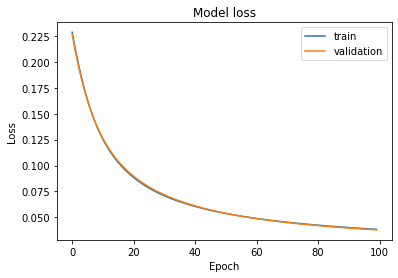

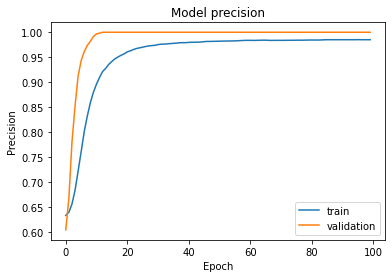

In [116]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
history = results[1][1]
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
#df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc= df_loss_acc[['precision','val_precision']]
df_acc.rename(columns={'precision':'train','val_precision':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model precision',figsize=(6,4)).set(xlabel='Epoch',ylabel='Precision')

# ...

In [ ]:
X_train, Y_train, grid = radiative_models.generate_opticallythin_spectra(10000)#generate_spectra(10000)
labels2 = [1 if i > 0.3 else 0 for i in grid.T[1]]
Y_train = np.array([Y_train, labels2]).T

X_test, Y_test, grid = radiative_models.generate_opticallythin_spectra(1000)
labels2 = [1 if i > 0.3 else 0 for i in grid.T[1]]
Y_test = np.array([Y_test, labels2]).T



X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

## Deep NN

In [40]:
def run_deepNN(X_train, Y_train, X_test, Y_test, neurons = 128, learning_rate=0.005, verbose=0):

    def make_NN_model(input_shape):
        input_data = tf.keras.Input(shape=input_shape)
        D1 = tf.keras.layers.Dense(units= neurons, activation='sigmoid')(input_data)
        outputs = tf.keras.layers.Dense(units= 1, activation='sigmoid')(D1)
        model = tf.keras.Model(inputs=input_data, outputs=outputs)
        return model

    NN_model = make_NN_model((X_train.shape[1],))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #opt = tf.keras.optimizers.SGD(lr=0.001)
    
    NN_model.compile(optimizer=opt,#,#clipnorm=1,#epsilon=1e-5
                     loss=tf.keras.losses.MeanSquaredError(),#'binary_crossentropy',#
                     metrics=[tf.keras.metrics.Precision(name='precision'), 
                               tf.keras.metrics.Recall(name='recall')])
    #NN_model.summary()

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

    history = NN_model.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=verbose)

    return history, NN_model

In [43]:
results = []
for alpha in [0.01,0.005]:
    for neurons in [64, 128, 256]:
        history, model = run_deepNN(X_train, Y_train, X_test, Y_test, \
                                    neurons = neurons, learning_rate=alpha, verbose=0)
        results.append([alpha, history, model])
        print('neurons: ', neurons, 'alpha: ', alpha, 'precision: ', history.history['val_precision'][-1], \
              'recall: ', history.history['val_recall'][-1])

neurons:  64 alpha:  0.01 precision:  0.9709924 recall:  0.99843013
neurons:  128 alpha:  0.01 precision:  0.9753846 recall:  0.9952904
neurons:  256 alpha:  0.01 precision:  0.9754601 recall:  0.99843013
neurons:  64 alpha:  0.005 precision:  1.0 recall:  0.96860284
neurons:  128 alpha:  0.005 precision:  0.9828125 recall:  0.9874411
neurons:  256 alpha:  0.005 precision:  0.9871175 recall:  0.96232337
